In [1]:
!pip install awswrangler --quiet
import pandas as pd
import numpy as np
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt

In [4]:
initial_query = 'SELECT * FROM "capstone_v3"."v3_telemetry" WHERE rand() <= 0.25 ORDER BY timestamp;'
samp = wr.athena.read_sql_query(
    sql=initial_query,
    database='capstone_v3',
    ctas_approach=True)

In [5]:
samp

timestamp  speed_desired  ambient_temperature  \
0       2021-11-26 09:22:13           1000                19.93   
1       2021-11-26 09:22:15           1000                20.04   
2       2021-11-26 09:22:15           1000                20.10   
3       2021-11-26 09:22:17           1000                20.06   
4       2021-11-26 09:22:17           1000                19.93   
...                     ...            ...                  ...   
6488308 2023-10-14 06:12:56           1000                20.02   
6488309 2023-10-14 06:12:59           1000                19.94   
6488310 2023-10-14 06:13:01           1000                19.91   
6488311 2023-10-14 06:13:05           1000                20.08   
6488312 2023-10-14 06:13:05           1000                20.06   

         ambient_pressure    speed  temperature  pressure machineid  
0                  100.93  1137.79       136.64   1536.45    M_0001  
1                  100.90  1143.92       136.76   1532.18    M_0001  
2                  101.09  1332.02       137.10   1895.93    M_0002  
3                  101.00  1335.17       137.09   1896.63    M_0002  
4                  100.90  1136.33       136.71   1544.43    M_0001  
...                   ...      ...          ...       ...       ...  
6488308            101.10  1207.77       138.70   1582.55    M_0009  
6488309            100.99  1208.77       138.63   1607.23    M_0009  
6488310            101.06  1208.97       138.62   1616.42    M_0009  
6488311            100.93  1097.65       137.10   1318.53    M_0024  
6488312            101.08  1208.90       138.80   1614.09    M_0009  

[6488313 rows x 8 columns]

We can see here, that we have 1000 unique machines. That's a lot of data coming in from each sensor. Keep in mind that this is only 1,500,000 of the records from the full dataset. The total number of records is over 13,000,000.

In [6]:
print(len(samp['machineid'].unique()))

25


### Exploring Speed

First, I want to explore the speed_desired field. For some records, it's 1000, and the rest is 0.

Text(0.5, 1.0, 'Distribution of Values for Desired Machine Speed')

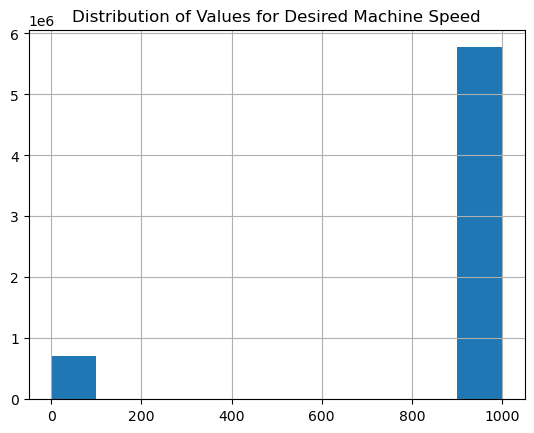

In [7]:
samp['speed_desired'].hist()
plt.title('Distribution of Values for Desired Machine Speed')

In [8]:
not1000 = samp[samp['speed_desired'] != 1000]

In [9]:
not1000.set_index('timestamp', inplace=True)

Here, I'm looking at the values for the actual speed vs. the desired speed and how it differs. For every machine I checked, there appears to be a common pattern. I assume the spikes are during uptime while the lulls are during machine downtime.

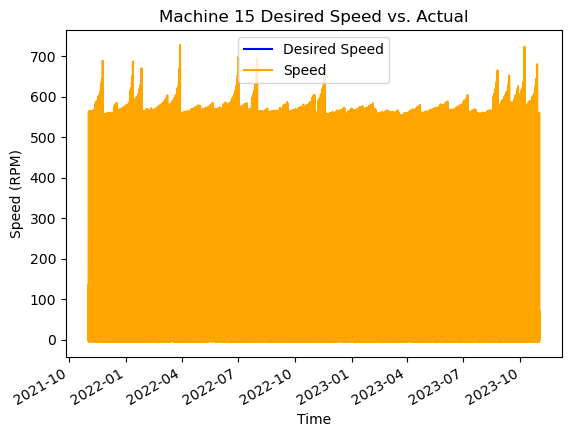

In [10]:
m15 = not1000[not1000['machineid'] == 'M_0015']
m15['speed_desired'].plot(label='Desired Speed', color='blue')
m15['speed'].plot(label='Speed', color='orange')

plt.title('Machine 15 Desired Speed vs. Actual')
plt.xlabel('Time')
plt.ylabel('Speed (RPM)')
plt.legend()

Below, looking at when the desired speed is 1000 for the same machine, it looks to be a similar pattern but inverted. The lulls appear to be downtime for the machine.

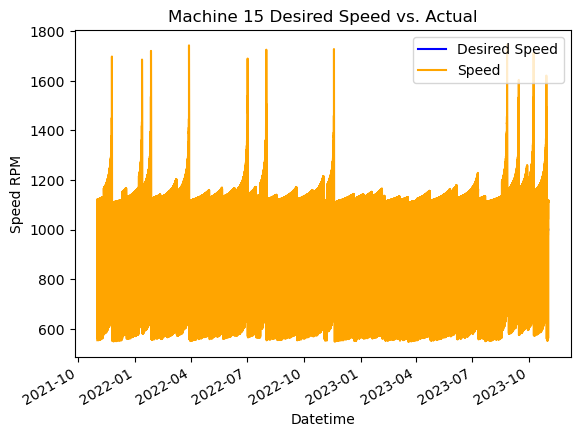

In [11]:
not0 = samp[samp['speed_desired'] != 0]
not0.set_index('timestamp', inplace=True)

m15_0 = not0[not0['machineid'] == 'M_0015']
m15_0['speed_desired'].plot(label='Desired Speed', color='blue')
m15_0['speed'].plot(label='Speed', color='orange')

plt.title('Machine 15 Desired Speed vs. Actual')
plt.xlabel('Datetime')
plt.ylabel('Speed RPM')
plt.legend()

Now, I'm going to check out the distributions for speeds to see if there's any noticeable outliers

Text(0, 0.5, 'Frequency')

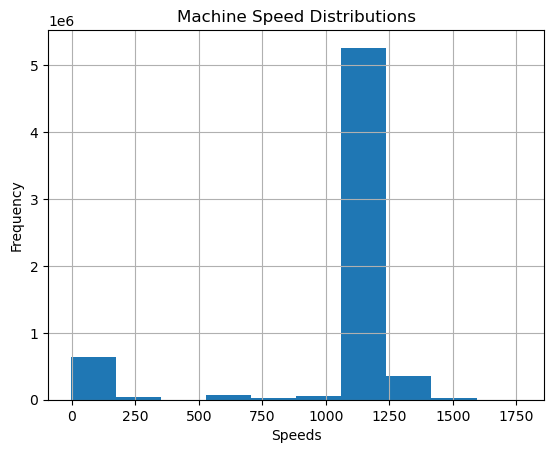

In [12]:
from matplotlib import cm

samp['speed'].hist()
plt.title('Machine Speed Distributions')
plt.xlabel('Speeds')
plt.ylabel('Frequency')

It appears that just over 10% of values fall 2 standard deviations away from the mean. Initially, looking into the instances of machines with speed under 325 RPM seemed to be a good approach for checking for potential issues. However, upon further research, negative or low RPM's aren't necessarily uncommon in industrial settings. It could just be one of the following reasons: underloaded or slow operation, error in measurement, or misinterpretation of data. These cases would require tuning/fixing the sensors.

In [13]:
too_low = samp['speed'].mean() - 2 * samp['speed'].std()
print(too_low)
filtered = samp[samp['speed'] < too_low]

print(str(np.round(len(filtered) / len(samp['speed']) * 100, 2)) + '%')

324.32413560099144
10.46%


But, I am still curious about the desired speed metric versus the actual speeed metric. What if some differences are abnormally high? So, the average differences in speed between the desired and actual appear to be around 130. Looking 1.5 standard deviations away from the mean, we have a difference of 232. These could be potential issues to check out for these machines posting these differences

In [14]:
samp['Speed Difference'] = abs(samp['speed_desired'] - samp['speed'])
too_high = samp['Speed Difference'].mean() + 1.5 * samp['Speed Difference'].std()
print(str(np.round(len(samp[samp['Speed Difference'] > too_high]) / len(samp) * 100, 2)) + '%')

5.82%


Text(0, 0.5, 'Frequency')

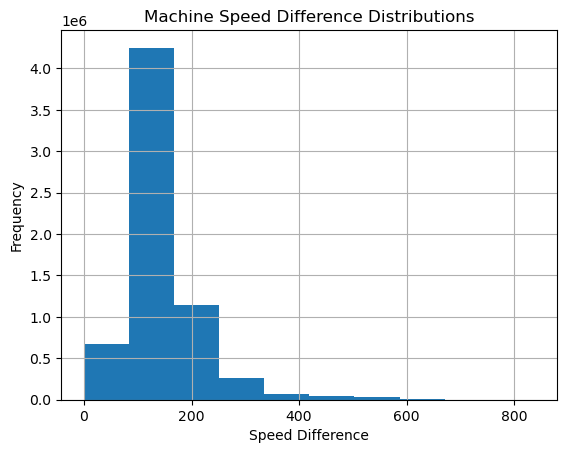

In [15]:
samp['Speed Difference'].hist()
plt.title('Machine Speed Difference Distributions')
plt.xlabel('Speed Difference')
plt.ylabel('Frequency')

From looking into speed, one of the criteria for evaluating risk will be the difference between the desired and the actual speed. More specifically, if the speed difference is over 230, then the records will be marked as having more risk for failure.

In [16]:
print(len(samp[samp['Speed Difference'] > 232]))
print(len(samp[samp['Speed Difference'] > 400]))
print(len(samp[samp['Speed Difference'] > 530]))
print(len(samp[samp['Speed Difference'] > 630]))

544030
102711
41985
2983


### Temperature

Now, let's look at the machine temperature (measured in Fahrenheit). Looking at the histogram, it doesn't look like there's any outliers on the lower end, but there seems to be some outliers on the higher end. High temperatures could be potentially dangerous for machines, endangering not only the factory but also people. Let's look more into the outliers.

Text(0.5, 1.0, 'Machine Temperatures')

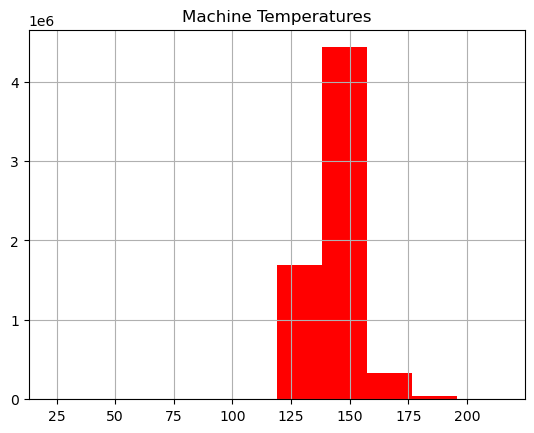

In [17]:
samp['temperature'].hist(color='red')
plt.title('Machine Temperatures')

In [18]:
too_low = samp['temperature'].mean() - 2 * samp['temperature'].std()
print(too_low)
too_high = samp['temperature'].mean() + 2 * samp['temperature'].std()
print(too_high)

127.76075946913498
158.6084171350145


What risks could low temperatures pose? It's not immediately clear, so I won't consider low outliers for risk calculation. If a machine's temperature is too high at any point in time, I will flag it with a higher risk score. 

In [19]:
print(str(len(samp[samp['temperature'] < too_low]) / len(samp) * 100) + '% is too low (less than -2 standard deviations from the mean)')
print(str(np.round(len(samp[samp['temperature'] > too_high]) / len(samp) * 100, 2)) + '% is too high (more than 2 standard deviations from the mean)')

0.0010480382188713768% is too low (less than -2 standard deviations from the mean)
4.87% is too high (more than 2 standard deviations from the mean)


In [20]:
samp[samp['temperature'] > 200]

timestamp  speed_desired  ambient_temperature  \
3733    2021-11-26 18:37:37           1000                19.91   
3734    2021-11-26 18:37:40           1000                20.03   
3735    2021-11-26 18:37:42           1000                19.96   
3736    2021-11-26 18:37:46           1000                20.00   
16894   2022-01-13 06:20:40              0                19.94   
...                     ...            ...                  ...   
6465118 2023-08-27 03:51:39           1000                20.05   
6465121 2023-08-27 03:51:46           1000                20.04   
6472257 2023-08-26 09:10:29           1000                20.05   
6472258 2023-08-26 09:10:34           1000                19.95   
6472259 2023-08-26 09:10:36           1000                19.97   

         ambient_pressure    speed  temperature  pressure machineid  \
3733               100.96  1129.22       200.68    308.61    M_0009   
3734               101.05  1127.35       203.05    280.50    M_0009   
3735               100.95  1125.33       205.36    285.80    M_0009   
3736               101.08  1124.79       214.92    204.82    M_0009   
16894              101.06   614.22       205.31    156.24    M_0014   
...                   ...      ...          ...       ...       ...   
6465118            101.05  1209.27       202.08    358.29    M_0023   
6465121            100.93  1210.32       214.86    207.23    M_0023   
6472257            100.91  1141.37       200.55    332.28    M_0017   
6472258            101.00  1136.81       205.37    273.31    M_0017   
6472259            101.06  1139.44       208.52    256.03    M_0017   

         Speed Difference  
3733               129.22  
3734               127.35  
3735               125.33  
3736               124.79  
16894              614.22  
...                   ...  
6465118            209.27  
6465121            210.32  
6472257            141.37  
6472258            136.81  
6472259            139.44  

[2004 rows x 9 columns]

In [21]:
samp[samp['temperature'] > 200]

timestamp  speed_desired  ambient_temperature  \
3733    2021-11-26 18:37:37           1000                19.91   
3734    2021-11-26 18:37:40           1000                20.03   
3735    2021-11-26 18:37:42           1000                19.96   
3736    2021-11-26 18:37:46           1000                20.00   
16894   2022-01-13 06:20:40              0                19.94   
...                     ...            ...                  ...   
6465118 2023-08-27 03:51:39           1000                20.05   
6465121 2023-08-27 03:51:46           1000                20.04   
6472257 2023-08-26 09:10:29           1000                20.05   
6472258 2023-08-26 09:10:34           1000                19.95   
6472259 2023-08-26 09:10:36           1000                19.97   

         ambient_pressure    speed  temperature  pressure machineid  \
3733               100.96  1129.22       200.68    308.61    M_0009   
3734               101.05  1127.35       203.05    280.50    M_0009   
3735               100.95  1125.33       205.36    285.80    M_0009   
3736               101.08  1124.79       214.92    204.82    M_0009   
16894              101.06   614.22       205.31    156.24    M_0014   
...                   ...      ...          ...       ...       ...   
6465118            101.05  1209.27       202.08    358.29    M_0023   
6465121            100.93  1210.32       214.86    207.23    M_0023   
6472257            100.91  1141.37       200.55    332.28    M_0017   
6472258            101.00  1136.81       205.37    273.31    M_0017   
6472259            101.06  1139.44       208.52    256.03    M_0017   

         Speed Difference  
3733               129.22  
3734               127.35  
3735               125.33  
3736               124.79  
16894              614.22  
...                   ...  
6465118            209.27  
6465121            210.32  
6472257            141.37  
6472258            136.81  
6472259            139.44  

[2004 rows x 9 columns]

In [22]:
samp[samp['temperature'] > 200]

timestamp  speed_desired  ambient_temperature  \
3733    2021-11-26 18:37:37           1000                19.91   
3734    2021-11-26 18:37:40           1000                20.03   
3735    2021-11-26 18:37:42           1000                19.96   
3736    2021-11-26 18:37:46           1000                20.00   
16894   2022-01-13 06:20:40              0                19.94   
...                     ...            ...                  ...   
6465118 2023-08-27 03:51:39           1000                20.05   
6465121 2023-08-27 03:51:46           1000                20.04   
6472257 2023-08-26 09:10:29           1000                20.05   
6472258 2023-08-26 09:10:34           1000                19.95   
6472259 2023-08-26 09:10:36           1000                19.97   

         ambient_pressure    speed  temperature  pressure machineid  \
3733               100.96  1129.22       200.68    308.61    M_0009   
3734               101.05  1127.35       203.05    280.50    M_0009   
3735               100.95  1125.33       205.36    285.80    M_0009   
3736               101.08  1124.79       214.92    204.82    M_0009   
16894              101.06   614.22       205.31    156.24    M_0014   
...                   ...      ...          ...       ...       ...   
6465118            101.05  1209.27       202.08    358.29    M_0023   
6465121            100.93  1210.32       214.86    207.23    M_0023   
6472257            100.91  1141.37       200.55    332.28    M_0017   
6472258            101.00  1136.81       205.37    273.31    M_0017   
6472259            101.06  1139.44       208.52    256.03    M_0017   

         Speed Difference  
3733               129.22  
3734               127.35  
3735               125.33  
3736               124.79  
16894              614.22  
...                   ...  
6465118            209.27  
6465121            210.32  
6472257            141.37  
6472258            136.81  
6472259            139.44  

[2004 rows x 9 columns]

### Exploring Pressure

Now, let's look at pressure (measured in kilopascal). In this context, pressure measures the force of a liquid within the system. 

Text(0, 0.5, 'Frequency')

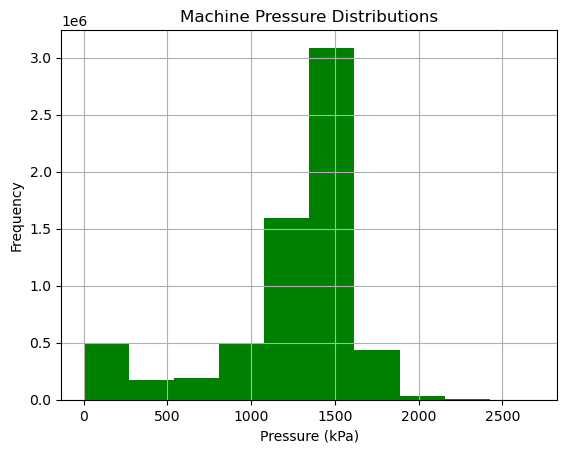

In [23]:
samp['pressure'].hist(color='green')
plt.title('Machine Pressure Distributions')
plt.xlabel('Pressure (kPa)')
plt.ylabel('Frequency')

In [24]:
too_low = samp['pressure'].mean() - 2 * samp['pressure'].std()
print(too_low)
too_high = samp['pressure'].mean() + 2 * samp['pressure'].std()
print(too_high)

405.26610433174255
2081.245044594028


It looks like we have a case of outliers on the lower end. There are a small amount on the higher end, so I'll consider those when evaluating risk, but about 9% of records are much too low. What could low pressure mean? Could be anything from leakages, worn out parts, or a faulty sensor. In any case, action should be taken to fix this. Meanwhile, high pressure could be a result of excessive load or an obstruction.

In [25]:
print(str(np.round(len(samp[samp['pressure'] <  too_low]) / len(samp) * 100, 2)) + '% is too low (less than -2 standard deviations from the mean)')
print(str(np.round(len(samp[samp['pressure'] > too_high]) / len(samp) * 100, 2)) + '% is too high (more than 2 standard deviations from the mean)')

8.81% is too low (less than -2 standard deviations from the mean)
0.12% is too high (more than 2 standard deviations from the mean)


### Exploring Ambient Temperature and Ambient Pressure

Looking at the histograms for these metrics, it doesn't seem like there's any outliers, but I'll check just in case. 

Text(0, 0.5, 'Frequency')

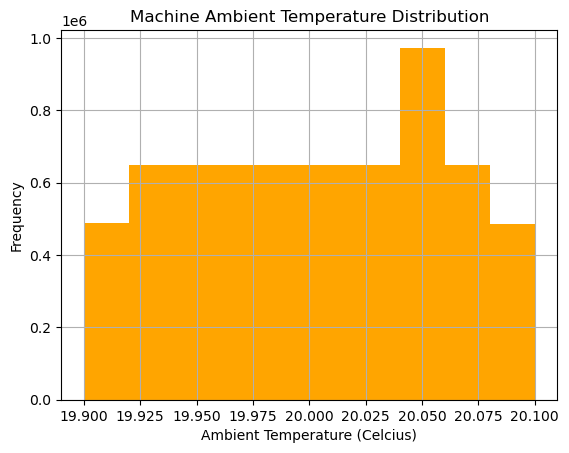

In [26]:
samp['ambient_temperature'].hist(color='orange')
plt.title('Machine Ambient Temperature Distribution')
plt.xlabel('Ambient Temperature (Celcius)')
plt.ylabel('Frequency')

As we can see, none of the values for ambient temperature are classified as outliers. Let's move onto ambient pressure. As we can see from the plots and the outlier check, there is nothing out of the ordinary here. 

In [27]:
too_low = samp['ambient_temperature'].mean() - 2 * samp['ambient_temperature'].std()
print(too_low)
too_high = samp['ambient_temperature'].mean() + 2 * samp['ambient_temperature'].std()
print(too_high)

19.88424265351374
20.115771837155844


In [28]:
print(str(np.round(len(samp[samp['ambient_temperature'] <  too_low]) / len(samp) * 100, 2)) + '% is too low (less than -2 standard deviations from the mean)')
print(str(np.round(len(samp[samp['ambient_temperature'] > too_high]) / len(samp) * 100, 2)) + '% is too high (more than 2 standard deviations from the mean)')

0.0% is too low (less than -2 standard deviations from the mean)
0.0% is too high (more than 2 standard deviations from the mean)


Text(0, 0.5, 'Frequency')

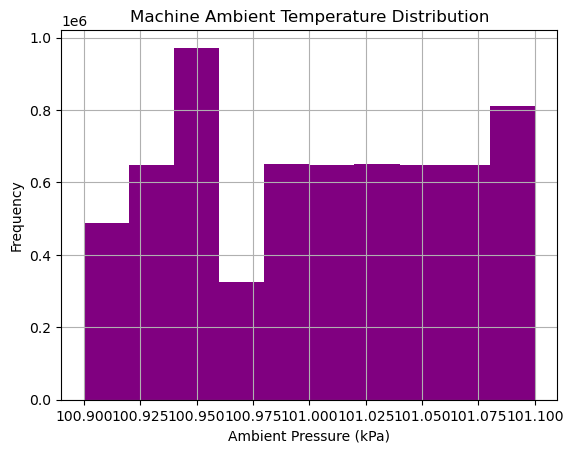

In [29]:
samp['ambient_pressure'].hist(color='purple')
plt.title('Machine Ambient Temperature Distribution')
plt.xlabel('Ambient Pressure (kPa)')
plt.ylabel('Frequency')

In [30]:
too_low = samp['ambient_pressure'].mean() - 2 * samp['ambient_pressure'].std()
print(too_low)
too_high = samp['ambient_pressure'].mean() + 2 * samp['ambient_pressure'].std()
print(too_high)

100.88423000231094
101.11575110217666


In [31]:
print(str(np.round(len(samp[samp['ambient_pressure'] <  too_low]) / len(samp) * 100, 2)) + '% is too low (less than -2 standard deviations from the mean)')
print(str(np.round(len(samp[samp['ambient_pressure'] > too_high]) / len(samp) * 100, 2)) + '% is too high (more than 2 standard deviations from the mean)')

0.0% is too low (less than -2 standard deviations from the mean)
0.0% is too high (more than 2 standard deviations from the mean)


So, the criteria that I'll use for evaluating risk in machine health is as below:
- Speed Difference
    - Over 232 RPM -> Risk
    - Over 400 RPM -> Slightly Higher Risk
    - Over 500 RPM -> Higher Risk
    - Over 600 RPM -> Highest Risk
- Temperature
    - Over 150 Degrees (F) -> Risk
    - Over 175 Degrees (F) -> Higher Risk
    - Over 200 Degrees (F) -> Highest Risk
- Pressure
    - Below 482 kPa
    - Above 2114 kPa

In [32]:
final_df = samp.drop(['speed_desired', 'ambient_temperature', 'ambient_pressure'], axis=1)

In [33]:
final_df

timestamp    speed  temperature  pressure machineid  \
0       2021-11-26 09:22:13  1137.79       136.64   1536.45    M_0001   
1       2021-11-26 09:22:15  1143.92       136.76   1532.18    M_0001   
2       2021-11-26 09:22:15  1332.02       137.10   1895.93    M_0002   
3       2021-11-26 09:22:17  1335.17       137.09   1896.63    M_0002   
4       2021-11-26 09:22:17  1136.33       136.71   1544.43    M_0001   
...                     ...      ...          ...       ...       ...   
6488308 2023-10-14 06:12:56  1207.77       138.70   1582.55    M_0009   
6488309 2023-10-14 06:12:59  1208.77       138.63   1607.23    M_0009   
6488310 2023-10-14 06:13:01  1208.97       138.62   1616.42    M_0009   
6488311 2023-10-14 06:13:05  1097.65       137.10   1318.53    M_0024   
6488312 2023-10-14 06:13:05  1208.90       138.80   1614.09    M_0009   

         Speed Difference  
0                  137.79  
1                  143.92  
2                  332.02  
3                  335.17  
4                  136.33  
...                   ...  
6488308            207.77  
6488309            208.77  
6488310            208.97  
6488311             97.65  
6488312             208.9  

[6488313 rows x 6 columns]

In [34]:
wr.s3.to_parquet(
    dataset=True,
    df=final_df,
    database='capstone_v3',
    path="s3://predictive-maintenance-capstone-sn/data/telemetry_v3/",
    table='telemetry_extended_v3')

{'paths': ['s3://predictive-maintenance-capstone-sn/data/telemetry_v3/3d787eb3c4bd482d8bce673db0e4564d.snappy.parquet'],
 'partitions_values': {}}

In [35]:
final_df

timestamp    speed  temperature  pressure machineid  \
0       2021-11-26 09:22:13  1137.79       136.64   1536.45    M_0001   
1       2021-11-26 09:22:15  1143.92       136.76   1532.18    M_0001   
2       2021-11-26 09:22:15  1332.02       137.10   1895.93    M_0002   
3       2021-11-26 09:22:17  1335.17       137.09   1896.63    M_0002   
4       2021-11-26 09:22:17  1136.33       136.71   1544.43    M_0001   
...                     ...      ...          ...       ...       ...   
6488308 2023-10-14 06:12:56  1207.77       138.70   1582.55    M_0009   
6488309 2023-10-14 06:12:59  1208.77       138.63   1607.23    M_0009   
6488310 2023-10-14 06:13:01  1208.97       138.62   1616.42    M_0009   
6488311 2023-10-14 06:13:05  1097.65       137.10   1318.53    M_0024   
6488312 2023-10-14 06:13:05  1208.90       138.80   1614.09    M_0009   

         Speed Difference  
0                  137.79  
1                  143.92  
2                  332.02  
3                  335.17  
4                  136.33  
...                   ...  
6488308            207.77  
6488309            208.77  
6488310            208.97  
6488311             97.65  
6488312             208.9  

[6488313 rows x 6 columns]